<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Tradevesting/myStocks_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''
import os

# Install es_MX
!/usr/share/locales/install-language-pack en_IN
!dpkg-reconfigure locales

# Restart Python process to pick up the new locales
os.kill(os.getpid(), 9)
'''

'\nimport os\n\n# Install es_MX\n!/usr/share/locales/install-language-pack en_IN\n!dpkg-reconfigure locales\n\n# Restart Python process to pick up the new locales\nos.kill(os.getpid(), 9)\n'

In [2]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2023-08-01 16:43:34


In [3]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

In [4]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta
import locale
locale.setlocale(locale.LC_MONETARY, 'en_IN')

'en_IN'

In [5]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-10*365)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')

In [6]:
# fetch nifty200 scrips

import pandas as pd
import numpy as np

mypf = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myProspectsScrips.csv')

myts = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Data-Science-with-Python/master/Tradevesting/myTransactionsReport.csv')

mypf = mypf[mypf['InPortfolio'] == 1]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol'].unique()

stock_ids = stock_n100

#mypf = mypf[mypf.Forecast.notnull()]
#stock_ids = mypf['Symbol'].unique()

stock_ids.sort()
stock_ids

array(['5PAISA', 'AAVAS', 'AMARAJABAT', 'AMBUJACEM', 'BAJAJFINSV',
       'BAJAJHIND', 'BANDHANBNK', 'BATAINDIA', 'BAYERCROP', 'CAMS',
       'CDSL', 'CLEAN', 'DMART', 'EICHERMOT', 'EMAMILTD', 'FINEORG',
       'GICRE', 'GILLETTE', 'GLAND', 'HDFCAMC', 'HDFCBANK', 'ICICIGI',
       'INDIGOPNTS', 'INDUSINDBK', 'INFY', 'IRCTC', 'ITBEES', 'J&KBANK',
       'JMFINANCIL', 'JUBLFOOD', 'KOTAKBANK', 'LTIM', 'LUXIND',
       'METROPOLIS', 'NIACL', 'NMDC', 'PAGEIND', 'PIDILITIND', 'PNB',
       'RAJESHEXPO', 'RELAXO', 'ROSSARI', 'SAIL', 'SRF', 'STARHEALTH',
       'SUNTV', 'TCS', 'TEAMLEASE', 'UJJIVANSFB', 'VAIBHAVGBL',
       'VALIANTORG', 'WIPRO'], dtype=object)

In [7]:
# function to compute stock attributes
def get_common_features():
  def stock_prec_dev(stock_symbol):
      #stock_symbol = 'ULTRACEMCO.NS'
      short_window = 20
      mid_window = 50
      long_window = 200
      moving_avg = 'SMA'

      # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
      start = datetime.datetime(*map(int, start_date.split('-')))
      end = datetime.datetime(*map(int, end_date.split('-')))
      stock_df = yfin.Ticker(stock_symbol).history(period='10y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
      stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
      stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
      stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
      stock_df.dropna(axis = 0, inplace = True) # remove any null rows

      stock_df['Stock'] = stock_symbol

      stock_df['Close'] = round(stock_df['Close'],2)
      stock_df['Max'] = round(max(stock_df['Close']),0)
      stock_df.ta.rsi(append=True)
      #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
      stock_df['Close'] = round(stock_df['Close'],0)
      stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
      stock_df.drop(['Open', 'Low', 'High', 'Volume'
                    ], axis=1, inplace=True)

      return stock_df

  df_prec_dev = pd.DataFrame()

  #tmp = stock_prec_dev('ULTRACEMCO.NS')
  #df_perform = df_perform.append(tmp)
  for stock_id in stock_ids:
      #print(stock_id)
      #current_pe = get_current_pe(stock_id)
      stock_id = stock_id.upper() + '.NS'
      tmp = stock_prec_dev(stock_id)
      tmp['Prev_Close'] = tmp['Close'].shift(1)
      tmp = tmp.reset_index()
      tmp = tmp.tail(1)
      tmp['Avg_Cost'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['AvgCost'].values[0]
      tmp['Shares'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Shares'].values[0]
      tmp['Criteria'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Criteria'].values[0]
      tmp['Strategy'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Strategy'].values[0]
      tmp['Target'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Target'].values[0]
      tmp['LatestQtr'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['LatestQtr'].values[0]
      tmp['StarStock'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['StarStock'].values[0]
      tmp['Conviction'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Conviction'].values[0]
      tmp['Category'] = mypf[(mypf['Symbol']+'.NS') == stock_id.upper()]['Category'].values[0]
      #tmp['Curr_PE'] = current_pe
      df_prec_dev = df_prec_dev.append(tmp)

  return df_prec_dev

df_common_features = get_common_features()

In [8]:
df_common_features.reset_index(drop=True, inplace=True)
df_common_features.drop(['Date'], axis=1, inplace=True)

In [9]:
# portfolio stocks

def get_portfolio_features(df_common_features):

  #df_common_features["Target"] = df_common_features["Target"].fillna(df_common_features["Max"])
  df_common_features['Target'] = np.where(df_common_features['Strategy']== 'BTT', df_common_features["Target"], df_common_features['Max'])

  tmp_df = df_common_features[df_common_features['Stock'].isin(mypf[mypf['InPortfolio'] == 1].Stock.values)]
  print('qualified stocks: '+str(tmp_df.shape[0]))
  tmp_df1 = tmp_df[tmp_df['LatestQtr'] == 1]
  print('with latest results: '+str(tmp_df1.shape[0]))
  tmp_df1 = tmp_df1[tmp_df1['StarStock'] == 1]
  print('still star stocks: '+str(tmp_df1.shape[0]))
  tmp_df['Investment'] = tmp_df['Avg_Cost'] * tmp_df['Shares']
  tmp_df['Current'] = tmp_df['Close'] * tmp_df['Shares']
  tmp_df['Previous'] = tmp_df['Prev_Close'] * tmp_df['Shares']
  tmp_df['Estimated'] = tmp_df['Target'] * tmp_df['Shares']
  tmp_df['Today P/L%'] = round((tmp_df['Current'] - tmp_df['Previous'])*100/tmp_df['Previous'],2)
  tmp_df['Current P/L%'] = round((tmp_df['Current'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['Estimated P/L%'] = round((tmp_df['Estimated'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['Juice Left%'] = tmp_df['Estimated P/L%'] - tmp_df['Current P/L%']
  investment = round(sum(tmp_df['Avg_Cost']*tmp_df['Shares']),0)
  tmp_df['Weightage%'] = round(tmp_df['Investment']*100/investment,2)
  tmp_df['Risk Ind'] = round(tmp_df['Current P/L%']*tmp_df['Weightage%'],0)

  return tmp_df

df_portfolio_features = get_portfolio_features(df_common_features)

def print_portfolio_stats(df_portfolio_features):
  investment = round(sum(df_portfolio_features['Avg_Cost']*df_portfolio_features['Shares']),0)
  current = round(sum(df_portfolio_features['Close']*df_portfolio_features['Shares']),0)
  previous = round(sum(df_portfolio_features['Prev_Close']*df_portfolio_features['Shares']),0)

  today_pnl_amount = current-previous
  today_pnl_percentage = round((current-previous)*100/previous,2)

  curr_pnl_amount = current-investment
  curr_pnl_percentage = round((current-investment)*100/investment,2)

  estimate = round(sum(df_portfolio_features['Max']*df_portfolio_features['Shares']),0)
  est_pnl_amount = estimate-investment
  est_pnl_percentage = round((estimate-investment)*100/investment,2)

  total_profit = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Investment']),0)
  total_loss = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Investment']),0)

  print('-------------------')
  print('Investment: ', locale.currency(investment, grouping=True))
  print('Current: ',  locale.currency(current, grouping=True))
  print('Today PnL: ',  locale.currency(today_pnl_amount, grouping=True))
  print('Today PnL %: ', today_pnl_percentage)
  print('Current PnL: ',  locale.currency(curr_pnl_amount, grouping=True))
  print('Current PnL %: ', curr_pnl_percentage)
  print('Estimate: ',  locale.currency(estimate, grouping=True))
  print('Estimate PnL: ',  locale.currency(est_pnl_amount, grouping=True))
  print('Estimate PnL %: ', est_pnl_percentage)
  print('-------------------')
  print('Total profit: ', locale.currency(total_profit, grouping=True))
  print('Total loss: ', locale.currency(total_loss, grouping=True))

print_portfolio_stats(df_portfolio_features)

qualified stocks: 52
with latest quarter: 21
still star stocks: 15
-------------------
Investment:  ₹34,65,045.00
Current:  ₹37,29,224.00
Today PnL:  ₹55,473.00
Today PnL %:  1.51
Current PnL:  ₹2,64,179.00
Current PnL %:  7.62
Estimate:  ₹64,64,922.00
Estimate PnL:  ₹29,99,877.00
Estimate PnL %:  86.58
-------------------
Total profit:  ₹2,88,233.00
Total loss:  -₹24,054.00


In [10]:
cols = ['Stock', 'Close', 'Dev%_200', 'RSI_14', 'Target', 'Avg_Cost', 'Shares', 'Today P/L%', 'Current P/L%', 'Estimated P/L%', 'Juice Left%', 'Weightage%', 'Risk Ind', 'LatestQtr', 'StarStock', 'Criteria', 'Strategy', 'Conviction', 'Category']
df_portfolio_features = df_portfolio_features[cols]

if gen_output == 1:
  from google.colab import drive
  drive.mount('/content/drive')
  df_portfolio_features.to_csv('/content/drive/My Drive/data/stocks/myStocks-Portfolio-Analysis.csv', index=False)

<Axes: title={'center': 'Concerns in this Quarter'}, xlabel='Stock'>

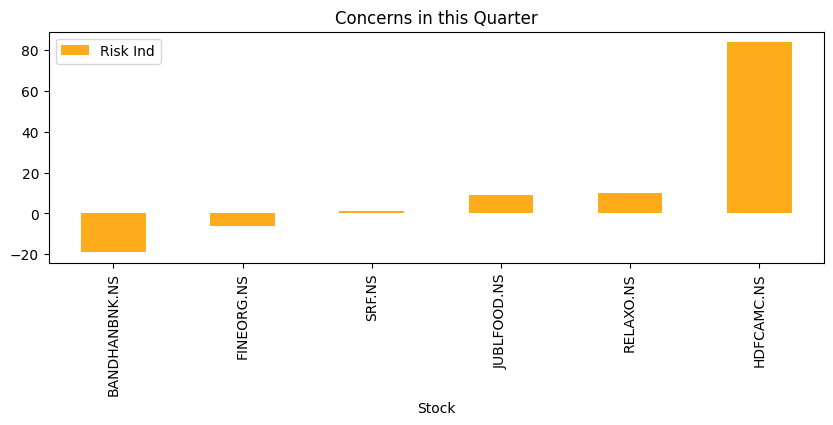

In [11]:
# concerns for this quarter
tmp_df = df_portfolio_features[(df_portfolio_features['LatestQtr'] == 1) & (df_portfolio_features['StarStock'] == 0)].sort_values(by = 'Risk Ind', ascending=True)
tmp_df.plot.bar(y='Risk Ind', x = 'Stock',  figsize=(10, 3), color='#FFAC1C', title='Concerns in this Quarter')

In [12]:
def plot_features_top_bottom(df_portfolio_features, column):
  fig, (ax1, ax2) = plt.subplots(1, 2)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=False).head(5)
  tmp_df.plot.bar(y=column, x = 'Stock',  figsize=(10, 3), color='#4CBB17', title='Top 5 in ' + column, ax=ax1)
  tmp_df = df_portfolio_features.sort_values(by = column, ascending=True).head(5)
  tmp_df.plot.bar(y=column, x = 'Stock', figsize=(10, 3), color='#FFAC1C', title='Bottom 5 in ' + column, ax=ax2)

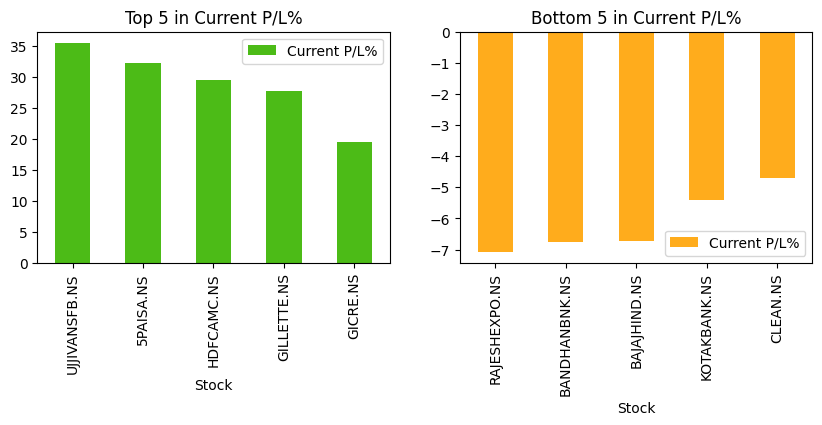

In [13]:
col = 'Current P/L%'
plot_features_top_bottom(df_portfolio_features, col)

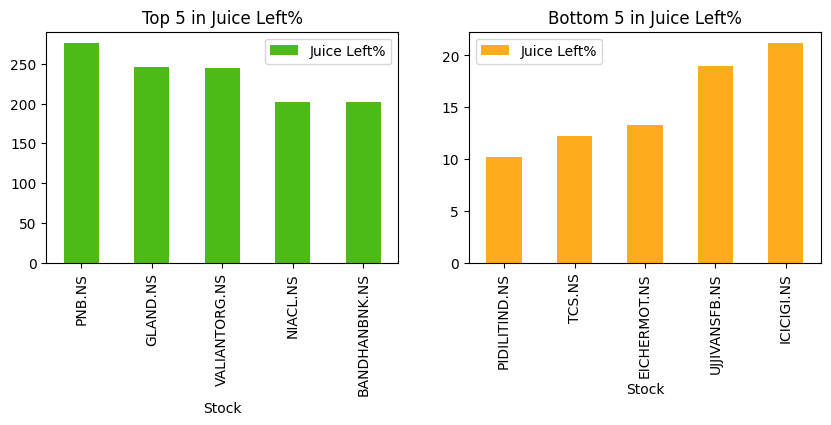

In [14]:
col = 'Juice Left%'
plot_features_top_bottom(df_portfolio_features, col)

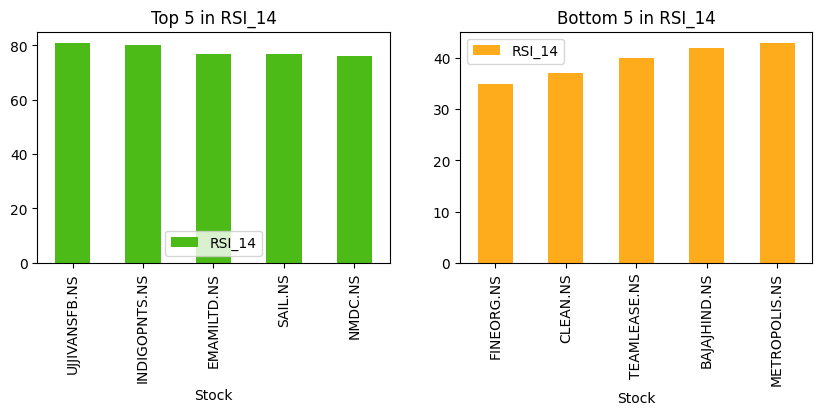

In [15]:
col = 'RSI_14'
plot_features_top_bottom(df_portfolio_features, col)

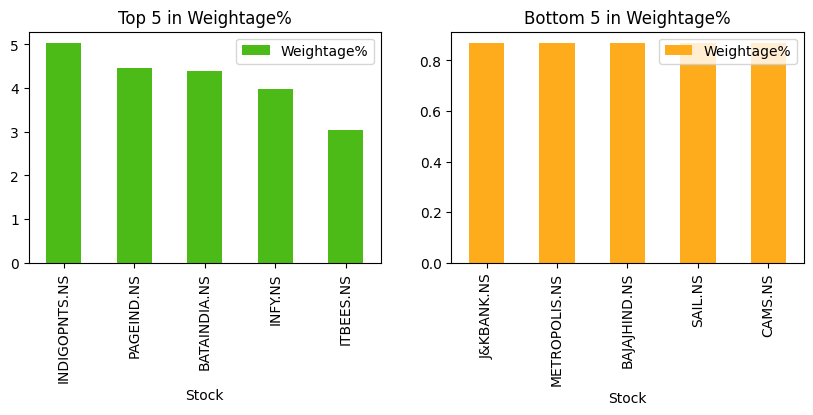

In [16]:
col = 'Weightage%'
plot_features_top_bottom(df_portfolio_features, col)

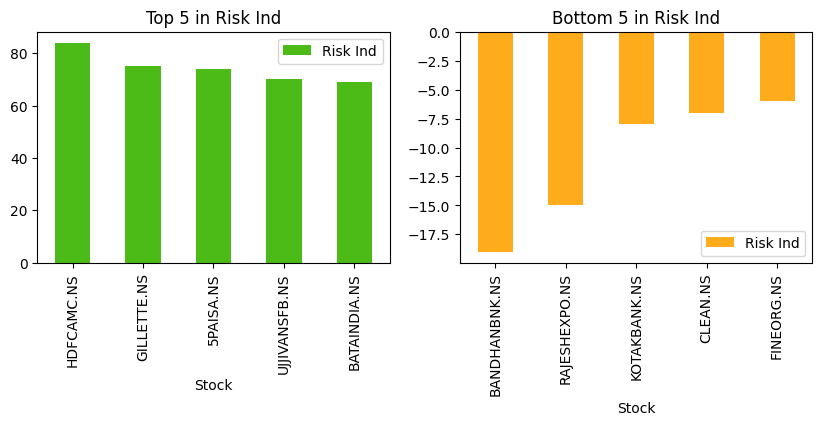

In [17]:
col = 'Risk Ind'
plot_features_top_bottom(df_portfolio_features, col)

In [18]:
def plot_feature_weights(df_portfolio_features, column):
  tmp_df = df_portfolio_features.groupby(column)['Weightage%'].agg(['sum'])
  tmp_df = tmp_df.rename({'sum': 'Weight%'}, axis='columns')
  tmp_df = tmp_df.sort_values(by = 'Weight%', ascending=False)
  tmp_df.plot.pie(y='Weight%', autopct='%1.0f%%', figsize=(5, 5), legend=False, title='Weight% in ' + column)

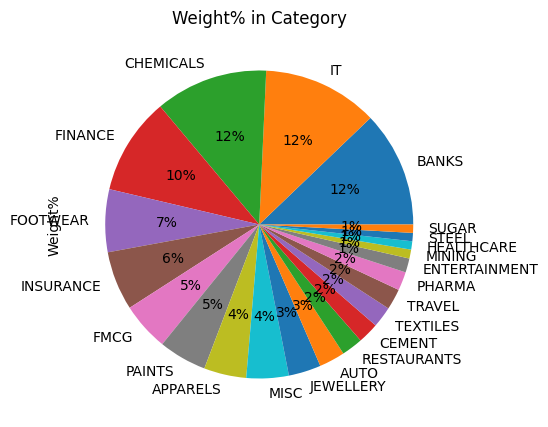

In [19]:
col = 'Category'
plot_feature_weights(df_portfolio_features, col)

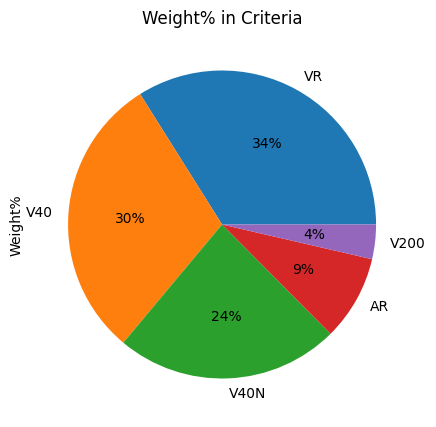

In [20]:
col = 'Criteria'
plot_feature_weights(df_portfolio_features, col)

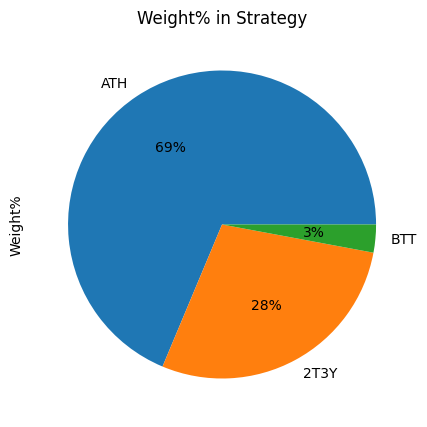

In [21]:
col = 'Strategy'
plot_feature_weights(df_portfolio_features, col)

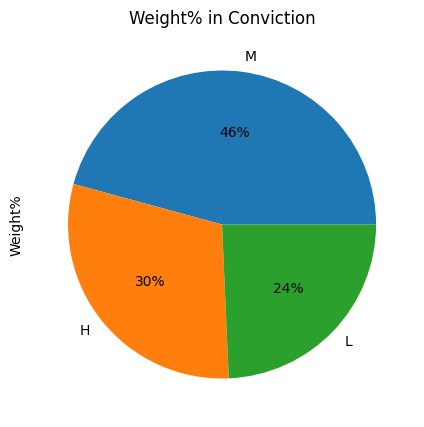

In [22]:
col = 'Conviction'
plot_feature_weights(df_portfolio_features, col)

In [23]:
df_portfolio_features.sort_values(by = 'Juice Left%', ascending=True)

,Stock,Close,Dev%_200,RSI_14,Target,Avg_Cost,Shares,Today P/L%,Current P/L%,Estimated P/L%,Juice Left%,Weightage%,Risk Ind,LatestQtr,StarStock,Criteria,Strategy,Conviction,Category
37,PIDILITIND.NS,2635.0,4.85,53.0,2890.0,2504.06,30.0,0.73,5.23,15.41,10.18,2.17,11.0,0,1.0,V40,ATH,H,CHEMICALS
46,TCS.NS,3452.0,6.48,61.0,3847.0,3231.00,16.0,2.89,6.84,19.07,12.23,1.49,10.0,1,1.0,V40,ATH,H,IT
13,EICHERMOT.NS,3416.0,2.09,54.0,3850.0,3260.20,15.0,1.82,4.78,18.09,13.31,1.41,7.0,0,1.0,V40N,ATH,H,AUTO
48,UJJIVANSFB.NS,50.0,65.50,81.0,57.0,36.90,1850.0,13.64,35.50,54.47,18.97,1.97,70.0,1,1.0,V40N,ATH,M,BANKS
21,ICICIGI.NS,1363.0,16.07,57.0,1613.0,1177.58,84.0,-0.80,15.75,36.98,21.23,2.85,45.0,1,1.0,V40,ATH,H,INSURANCE
30,KOTAKBANK.NS,1850.0,0.33,43.0,2270.0,1955.95,26.0,-1.44,-5.42,16.06,21.48,1.47,-8.0,1,1.0,V40,BTT,L,BANKS
4,BAJAJFINSV.NS,1572.0,6.10,46.0,1905.0,1454.93,52.0,-0.82,8.05,30.93,22.88,2.18,18.0,1,1.0,V40,ATH,H,FINANCE
20,HDFCBANK.NS,1662.0,3.83,50.0,2050.0,1683.55,30.0,1.09,-1.28,21.77,23.05,1.46,-2.0,1,1.0,V40,BTT,H,BANKS
26,ITBEES.NS,32.0,5.93,58.0,40.0,31.49,3350.0,3.23,1.62,27.02,25.40,3.04,5.0,0,1.0,AR,ATH,L,IT
43,SRF.NS,2251.0,-4.25,51.0,2821.0,2222.00,14.0,3.73,1.31,26.96,25.65,0.90,1.0,1,0.0,VR,ATH,M,CHEMICALS


In [24]:
#myts['Value'] = myts['Value'].str.replace(',', '').astype(float)

In [25]:
#sum(myts[(myts['Type'] == 'Buy')]['Value'])

In [26]:
#sum(myts[(myts['Type'] == 'Sell')]['Value'])